In [38]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate_toy as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
sys.path.append('../')
sys.path.append('../../code_Boyle')
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID_toy as model
reload(model)

<module 'read_model_ID_toy' from 'read_model_ID_toy.pyc'>

## Load data

In [2]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../../data_nucleaseq_Finkelsteinlab/targetE/'

xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../../Data_Boyle/',path_to_data,True)
_, ydatafull, yerrfull = processing.prepare_multiprocessing_combined('1',filename,'../../Data_Boyle/',path_to_data,False)

kclv = []
kon = []
i = 1
while i < 20+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0][0])
            kon.append(np.log10(ydata[a][1][0]))
            i = i + 1
    
kclv.append(ydata[0][0][0])
kclv = np.array(kclv)
kon.append(np.log10(ydata[0][1][0]))
kon =np.array(kon)


k_double = np.zeros([20,20])
on_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0][0])
        if len(ydata[a][1])>0:
            on_double[j-1,i-1] = np.log10(ydata[a][1][0])
        else:
            on_double[j-1,i-1] = np.nan
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
on_double_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))

## Load model

In [53]:
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '26' #use for cleavage fit
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '28'
#model_id = 'six_state_model_clv_constant_ei+six_state_model_on_constant_ei';parnum= '10'
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'


filename = 'fit_7_6_2019_sim_8_5.txt'
path = '../../fits_Stijn/7_6_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
parameters = np.array(final_par.values)

#parameters = np.append(np.append([1.4],parameters[:-2]),np.append([-2.4],parameters[-2:])) #use for cleavage fit

## Plots

Text(448.361,0.5,'Measured on-rate (Hz)')

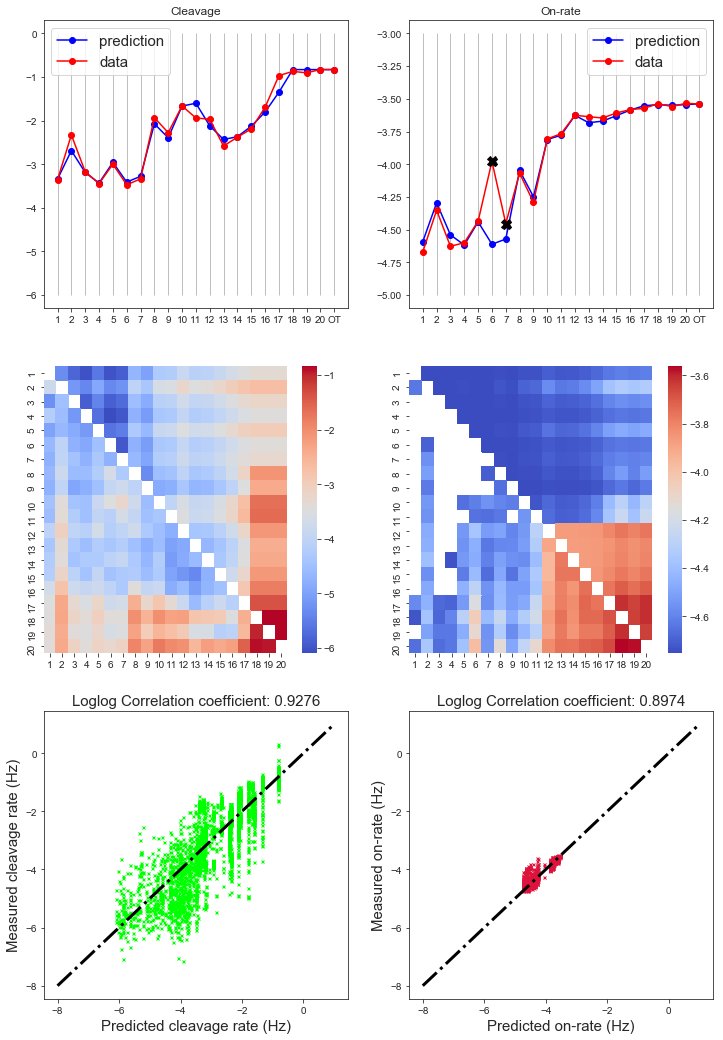

In [54]:
reload(clv)
k = np.zeros(21)
on = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k[i-1],on[i-1] = np.log10(clv.calc_clv_on(parameters,model_id,mismatch_positions))
k[-1],on[-1] = np.log10(clv.calc_clv_on(parameters,model_id,[]))

f,ax = plt.subplots(3,2,sharey=False,figsize=[12,18])
    
ax[0][0].plot(range(1,22),k,marker='o',color='blue')
ax[0][0].set_xticks(range(1,22));
ax[0][0].set_xticklabels(range(1,21)+['OT'])
ax[0][0].vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
ax[0][0].plot(range(1,22),kclv,marker='o',color='red')
ax[0][0].legend(['prediction','data'],fontsize=15)
ax[0][0].set_title('Cleavage')

ax[0][1].plot(range(1,22),on,marker='o',color='blue')
ax[0][1].set_xticks(range(1,22));
ax[0][1].set_xticklabels(range(1,21)+['OT'])
ax[0][1].vlines(range(1,22),-5,-3,linewidth=0.5,color='grey')
ax[0][1].plot(range(1,22),kon,marker='o',color='red')
ax[0][1].legend(['prediction','data'],fontsize=15)
ax[0][1].set_title('On-rate')
for i in range(21):
    if i+1==6 or i+1==7:
        ax[0][1].plot(i+1,kon[i],marker='X',color='k',markersize=10)

k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_double[i-1][j-1],on_double[i-1][j-1] = np.log10(clv.calc_clv_on(parameters,model_id,mismatch_positions))
        
k_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_df = k_df + k_double_df
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    
on_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
on_df = on_df + on_double_df
for i in range(1,21):
    on_df[i].loc[i]=np.nan
    
sns.heatmap(k_df, cmap='coolwarm', cbar=True,ax=ax[1][0])
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(on_df, cmap='coolwarm', cbar=True,ax=ax[1][1])
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

datacleave = []
fitcleave = []
dataon = []
fiton = []

for i in range(len(xdata)):
    cleavagetemp, ontemp = np.log10(clv.calc_clv_on(parameters,model_id,xdata[i]))
    for j in range(len(ydatafull[i][0])):
        if (ydatafull[i][0][j])>(-10):
            datacleave.append(ydatafull[i][0][j])
            fitcleave.append(cleavagetemp)
    for j in range(len(ydatafull[i][1])):        
        if ydatafull[i][1][j]>(-10):
            dataon.append(np.log10(ydatafull[i][1][j]))
            fiton.append(ontemp)
        
        
ax[2][0].plot(fitcleave,datacleave,marker='x',markersize=3,color='lime',linewidth=0.0)
ax[2][0].plot([-8,1],[-8,1],'k-.',linewidth=3)
#ax[2][0].set_axis([-8,1,-8,1])
ax[2][0].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datacleave,fitcleave])[0][1],4)), fontsize=15)
ax[2][0].set_xlabel('Predicted cleavage rate (Hz)',fontsize=15)
ax[2][0].set_ylabel('Measured cleavage rate (Hz)',fontsize=15)

ax[2][1].plot(fiton,dataon,marker='x',markersize=3,color='crimson',linewidth=0.0)
ax[2][1].plot([-8,1],[-8,1],'k-.',linewidth=3)
#plt.axis([-8,1,-8,1])
ax[2][1].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([dataon,fiton])[0][1],4)), fontsize=15)
ax[2][1].set_xlabel('Predicted on-rate (Hz)',fontsize=15)
ax[2][1].set_ylabel('Measured on-rate (Hz)',fontsize=15)

## Chi-squared evolution

780.034897254


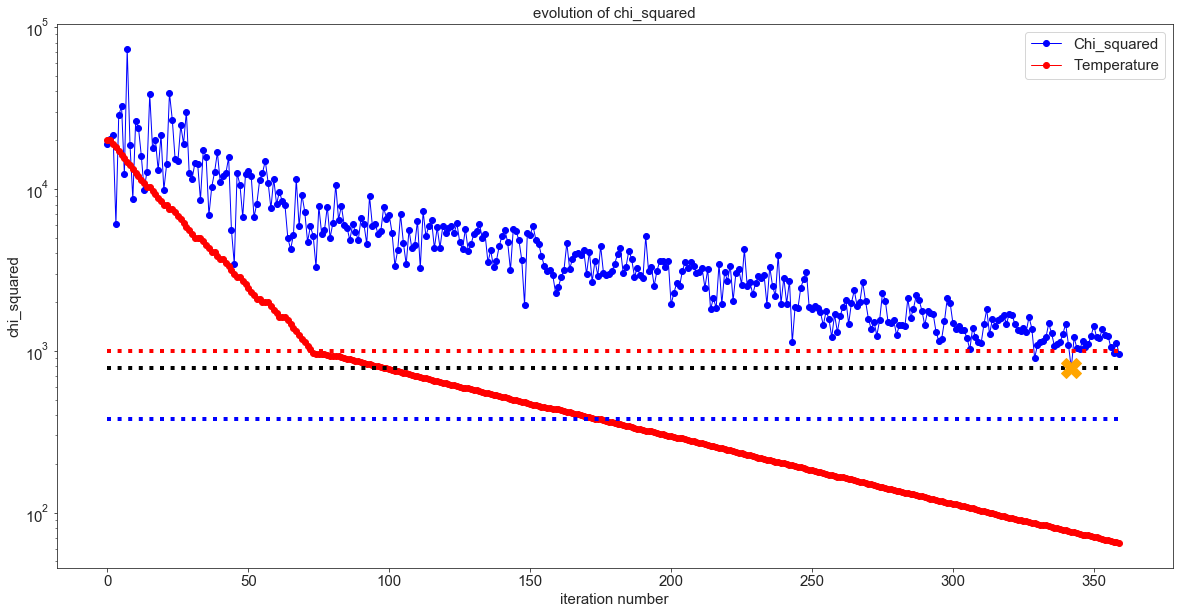

In [24]:
plt.figure(figsize=[20,10])
plt.plot(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(T, marker='o', linewidth=1, color='red')
plt.plot([0,len(chi)],[min(chi),min(chi)],linewidth=4,linestyle=':',color='k')
plt.plot([0,len(chi)],[380,380],linewidth=4,linestyle=':',color='b')
plt.plot([0,len(chi)],[1000,1000],linewidth=4,linestyle=':',color='r')
plt.semilogy(np.argmin(chi),min(chi),marker='X',markersize=20,color='orange')
plt.legend(['Chi_squared','Temperature'],fontsize=15)
print min(chi)

# Looking at batches of fits

In [48]:
simset = []
final_par = []
energies = []
rates = []

chi_squared = []

file = '../../fits_Stijn/7_6_2019/fit_7_6_2019_sim_8_'
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '26' #use for cleavage fit
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '28'
#model_id = 'six_state_model_clv_constant_ei+six_state_model_on_constant_ei';parnum= '10'
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'

#---------- collect simulations ---------------
for sim in range(1,6):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    
    #final_par_temp = np.append(np.append([1.4],final_par_temp[:-2]),np.append([-2.4],final_par_temp[-2:])) #use for cleavage fit
    id_clv,id_on,para_clv,para_on = model.combined_model(final_par_temp,model_id)
    
    epsilon,ratestemp = model.unpack_parameters(para_on,id_on)
    _,ratesclv = model.unpack_parameters(para_clv,id_clv)
    
    #epsilon[0] *= -1
    
    energies.append(epsilon)
    rates.append(np.append(ratestemp[0:3],ratesclv[-1]))
        
    final_par_temp[0] = -final_par_temp[0]
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]
print 'best fit: ' + best_fit
print 'all chi_squared: ' + str(chi_squared)

best fit: ../../fits_Stijn/7_6_2019/fit_7_6_2019_sim_8_5.txt
all chi_squared: [394.40690000300003, 400.51788568800004, 387.98672734900003, 536.203755115, 387.719303738]


5


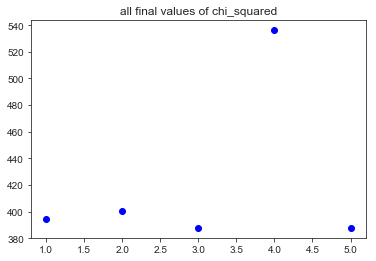

In [49]:
chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<5000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
rates_low_chi = np.array(rates)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
plt.plot(range(1,len(chi_squared)+1),chi_squared,'bo')
plt.title('all final values of chi_squared')

median = np.zeros(len(final_par_low_chi[0]))
median_energies = np.zeros(len(energies_low_chi[0]))
median_rates = np.zeros(len(rates_low_chi[0]))

for i in range(len(final_par_low_chi[0])):
    median_temp = list()
    for j in range(len(final_par_low_chi)):
        median_temp.append(final_par_low_chi[j][i])
    median[i] = np.median(np.array(median_temp))
    
for i in range(len(energies_low_chi[0])):
    median_temp = list()
    for j in range(len(energies_low_chi)):
        median_temp.append(energies_low_chi[j][i])
    median_energies[i] = np.median(np.array(median_temp))
    
for i in range(len(rates_low_chi[0])):
    median_temp = list()
    for j in range(len(rates_low_chi)):
        median_temp.append(rates_low_chi[j][i])
    median_rates[i] = np.median(np.array(median_temp))
    
print len(final_par_low_chi)

## Energies

[1.55712587 2.22402663 6.81600675]
[1.58922119 2.23218272 6.79255849]
[1.55467746 2.25061592 6.62902969]
[1.80374544 2.28086775 8.08458229]
[1.56418145 2.24290504 6.69459452]


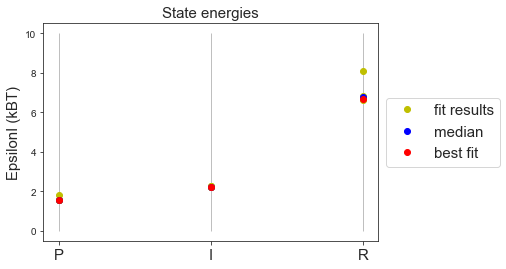

In [51]:
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,4),energies_low_chi[i][0:3],'yo',label='fit results')
    print energies_low_chi[i][0:3]
    
plot2, = plt.plot(range(1,4),median_energies[0:3],'bo',label='median')
plot3, = plt.plot(range(1,4),energies[np.argmin(chi_squared)][0:3],'ro',label='best fit')

plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
#plt.xlabel('position',fontsize=15)
plt.ylabel('EpsilonI (kBT)',fontsize=15)
plt.title('State energies',fontsize=15)
plt.vlines(range(1,4),0,10,color='grey',linewidth=0.5);
plt.xticks(range(1,4),['P','I','R'],fontsize=15,rotation='horizontal');

## Mismatches

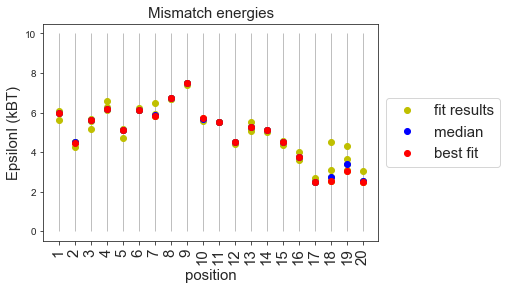

In [52]:
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,21),energies_low_chi[i][5:25],'yo',label='fit results')

plot2, = plt.plot(range(1,21),median_energies[5:25],'bo',label='median')
plot3, = plt.plot(range(1,21),energies[np.argmin(chi_squared)][5:25],'ro',label='best fit')
#plot4, = plt.plot(range(1,21),parameters[20:40],'ko',label='actual values')
plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('EpsilonI (kBT)',fontsize=15)
plt.title('Mismatch energies',fontsize=15)
plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');

## Rates

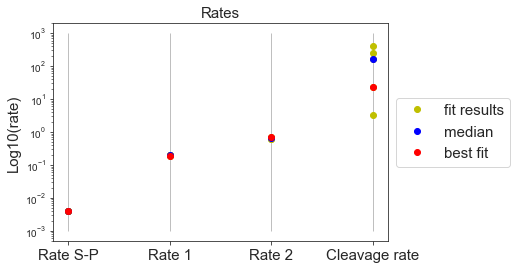

In [43]:
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,len(rates_low_chi[i])+1),rates_low_chi[i],'yo',label='fit results')
    
plot2, = plt.plot(range(1,len(rates_low_chi[i])+1),median_rates,'bo',label='median')
plot3, = plt.semilogy(range(1,len(rates_low_chi[i])+1),rates[np.argmin(chi_squared)],'ro',label='best fit')

plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.ylabel('Log10(rate)',fontsize=15)
plt.title('Rates',fontsize=15)
plt.vlines(range(1,len(rates_low_chi[i])+1),10**-3,10**3,color='grey',linewidth=0.5);
plt.xticks(range(1,len(rates_low_chi[i])+1),['Rate S-P','Rate 1','Rate 2','Cleavage rate'],fontsize=15);

## Landscape

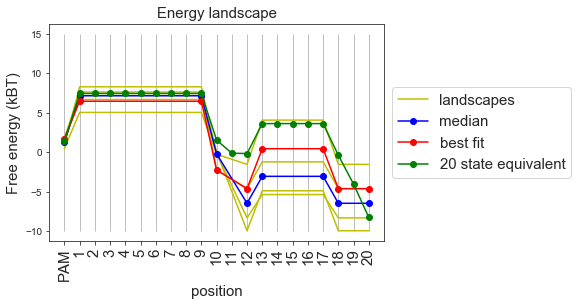

In [17]:
landscapes = np.zeros([len(energies_low_chi),9])

plt.figure()
for i in range(len(energies_low_chi)):
    epsilontemp = np.cumsum(np.append(energies[i][0], -energies[i][1:5]))
    epsilontemp = np.append(epsilontemp[0],np.append([epsilontemp[0] + energies_low_chi[i][5],epsilontemp[0] + energies_low_chi[i][5]],epsilontemp[1:]))
    epsilontemp = np.append(epsilontemp[0:5],np.append([epsilontemp[4] + energies_low_chi[i][6],epsilontemp[4] + energies_low_chi[i][6]],epsilontemp[5:]))
    plot1, = plt.plot([0,1,9,10,12,13,17,18,20],epsilontemp,'y-',label='landscapes')
    landscapes[i][:] = epsilontemp

medianls = np.median(landscapes, 0)
    
plot2, = plt.plot([0,1,9,10,12,13,17,18,20],medianls,'b-o', label='median') 

epsilontemp = np.cumsum(np.append(energies[np.argmin(chi_squared)][0], -energies[np.argmin(chi_squared)][1:5]))
epsilontemp = np.append(epsilontemp[0],np.append([epsilontemp[0] + energies[np.argmin(chi_squared)][5],epsilontemp[0] + energies[np.argmin(chi_squared)][5]],epsilontemp[1:]))
epsilontemp = np.append(epsilontemp[0:5],np.append([epsilontemp[4] + energies[np.argmin(chi_squared)][6],epsilontemp[4] + energies[np.argmin(chi_squared)][6]],epsilontemp[5:]))
plot3, = plt.plot([0,1,9,10,12,13,17,18,20],epsilontemp,marker='o',color='red',label='best fit')

landscape = np.zeros(21)
landscape[0] = 1.389248 #PAM Boyle, minus PAM Boyle :)
landscape[1:10] = np.ones(9)*7.44538973 #median height
landscape[10:13] = [1.547533, -0.105180, -0.153215] #well defined dip, from Boyle
landscape[13:18] = np.ones(5)*3.6374928 #median height
landscape[18:21] = [-0.361180,-4.009278,-8.223548] #well defined second dip, from Boyle

plot4, = plt.plot(range(0,21),landscape,marker='o',color='green',label='20 state equivalent')

plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('Free energy (kBT)',fontsize=15)
plt.title('Energy landscape',fontsize=15)
plt.vlines(range(0,21),-10,15,color='grey',linewidth=0.5);
plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');